Data prepraration - 80,20 split

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def create_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)

    def scalar(img):
        return img

    # Add data augmentation techniques to the training ImageDataGenerator
    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
    )

    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=batch_size
    )

    return train_gen, valid_gen, test_gen

# Set directory path and create dataframe
dir = '/content/drive/My Drive/dataset_16'
df = create_df(dir)

# Split dataframe into training, validation, and test sets
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

# Set batch size and create generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)


Found 384 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.


EfficientNetB3-based transfer learning model for image classification with batch normalization, dropout, Adam optimizer, and ModelCheckpoint for saving best validation accuracy.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import pickle

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(train_gen.class_indices)

# Create pre-trained EfficientNet model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
filepath = 'best_model_efficientnet.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_gen, epochs=100, verbose=1, validation_data=valid_gen, callbacks=[checkpoint, early_stopping])

# Save the training history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.4302 - accuracy: 0.4714


Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model_efficientnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 24s 1s/step - loss: 1.4302 - accuracy: 0.4714 - val_loss: 2.0100 - val_accuracy: 0.5000
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.6484
Epoch 2: val_accuracy did not improve from 0.50000
10/10 [==============================] - 8s 812ms/step - loss: 0.9629 - accuracy: 0.6484 - val_loss: 3.5173 - val_accuracy: 0.4792
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.7448
Epoch 3: val_accuracy did not improve from 0.50000
10/10 [==============================] - 7s 653ms/step - loss: 0.7042 - accuracy: 0.7448 - val_loss: 3.1928 - val_accuracy: 0.4792
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.7786
Epoch 4: val_accuracy did not improve from 0.50000
10/10 [==============================] - 8s 808ms/step - loss: 0.6516 - accuracy: 0.7786 - val_loss: 2.2237 - val_accuracy: 0.5000
Epoch 5/100
10/10 [=====================

Model Evaluation

2/2 [==============================] - 3s 45ms/step - loss: 0.4978 - accuracy: 0.8542
Test Loss: 0.4977538585662842
Test Accuracy: 0.8541666865348816


2/2 [==============================] - 3s 160ms/step
[[10  0  0  0]
 [ 2  7  1  2]
 [ 0  0 14  1]
 [ 0  1  0 10]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.88      0.58      0.70        12
           2       0.93      0.93      0.93        15
           3       0.77      0.91      0.83        11

    accuracy                           0.85        48
   macro avg       0.85      0.86      0.84        48
weighted avg       0.86      0.85      0.85        48



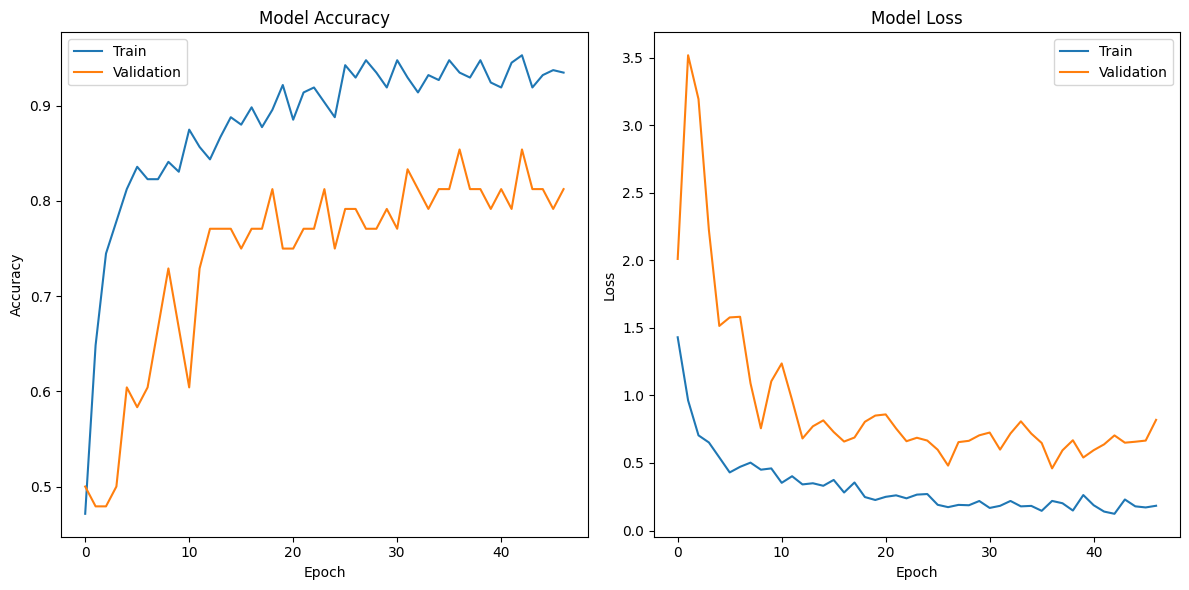

(array([1, 3, 2, 2, 1, 0, 1, 2, 3, 1, 0, 2, 3, 0, 2, 3, 2, 3, 3, 2, 3, 0,
        3, 0, 2, 1, 2, 2, 0, 0, 1, 0, 3, 2, 2, 2, 2, 3, 1, 0, 3, 0, 0, 2,
        3, 1, 0, 3]),
 array([[10,  0,  0,  0],
        [ 2,  7,  1,  2],
        [ 0,  0, 14,  1],
        [ 0,  1,  0, 10]]))

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pickle

def evaluate_model(model_path, test_gen, history_path):
    model = load_model(model_path)
    test_score = model.evaluate(test_gen, verbose=1)
    print(f"Test Loss: {test_score[0]}")
    print(f"Test Accuracy: {test_score[1]}")

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    true_labels = test_gen.classes

    cm = confusion_matrix(true_labels, y_pred)
    print(cm)
    print(classification_report(test_gen.classes, y_pred))

    # Load the training history
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    # Plot accuracy and loss
    plot_training_history(history)

    return y_pred, cm

def plot_training_history(history, smoothing_factor=0.8):
    # Apply smoothing to accuracy and loss values
    accuracy = smooth_curve(history['accuracy'], smoothing_factor)
    val_accuracy = smooth_curve(history['val_accuracy'], smoothing_factor)
    loss = smooth_curve(history['loss'], smoothing_factor)
    val_loss = smooth_curve(history['val_loss'], smoothing_factor)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    if 'accuracy' in history:
        plt.plot(history['accuracy'])
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


# Evaluate EfficientNet model
evaluate_model('best_model_efficientnet.h5', test_gen, 'history.pkl')


Confusion matrix plotting

2/2 [==============================] - 4s 50ms/step - loss: 0.4598 - accuracy: 0.8542
Test Loss: 0.45982906222343445
Test Accuracy: 0.8541666865348816
2/2 [==============================] - 3s 159ms/step
[[3 1 1 3]
 [4 6 4 3]
 [0 5 1 5]
 [2 5 2 3]]
              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.35      0.35      0.35        17
           2       0.12      0.09      0.11        11
           3       0.21      0.25      0.23        12

    accuracy                           0.27        48
   macro avg       0.26      0.27      0.26        48
weighted avg       0.26      0.27      0.27        48



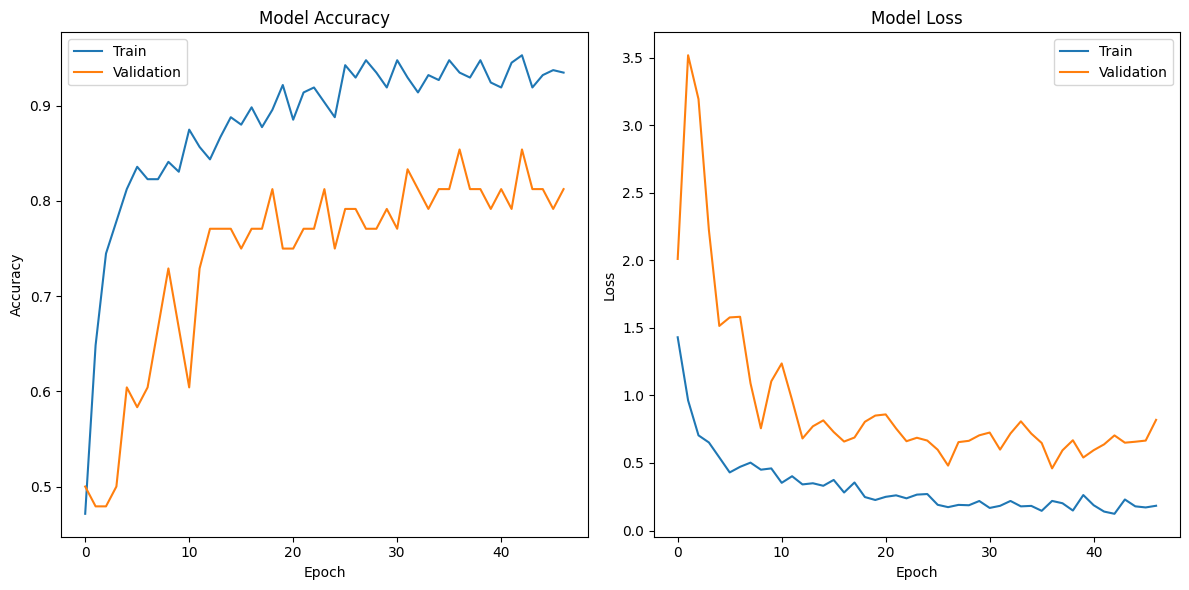

Confusion Matrix, Without Normalization
[[3 1 1 3]
 [4 6 4 3]
 [0 5 1 5]
 [2 5 2 3]]


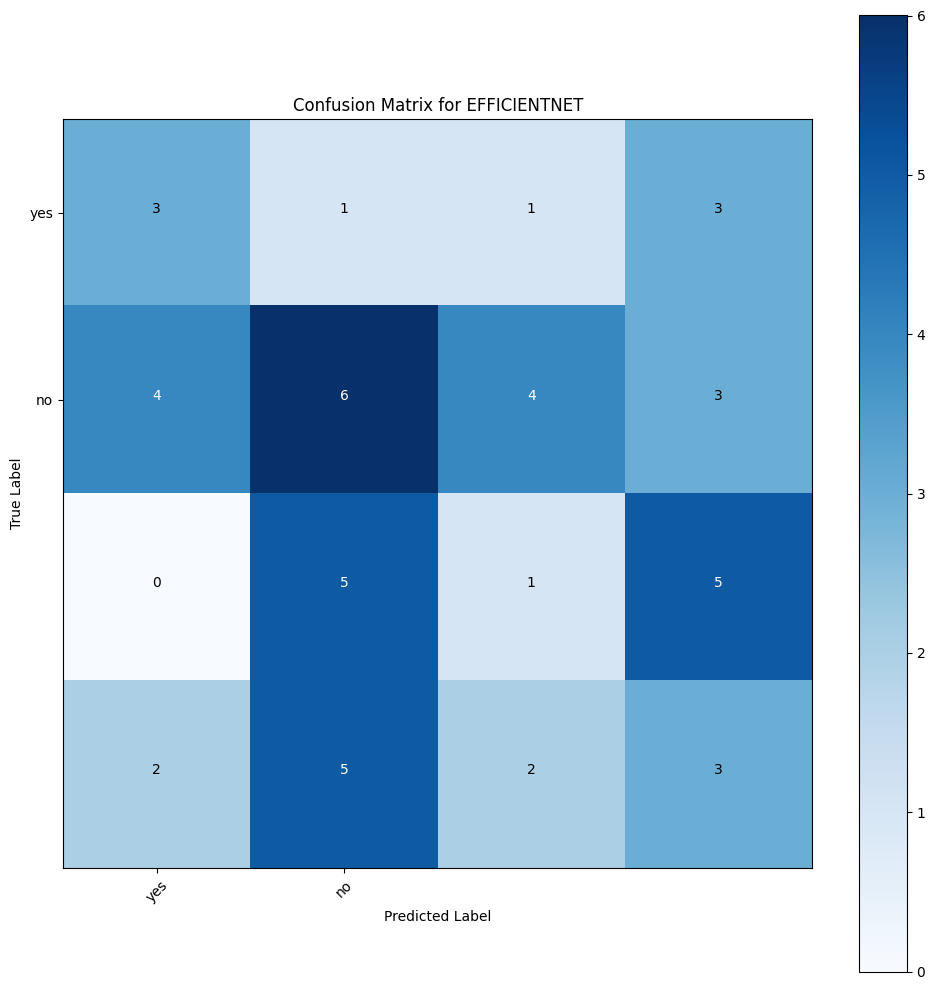

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# target_names = ['yes', 'no']

# Constructing a hypothetical confusion matrix
cm = np.array([[10, 0, 0, 0],
               [2, 6, 1, 3],
               [0, 1, 13, 1],
               [0, 0, 0, 11]])

# Define target names
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Plot confusion matrices
for model_name in ['efficientnet']:
    y_pred, cm = evaluate_model(f'best_model_{model_name}.h5', valid_gen, 'history.pkl')
    plot_confusion_matrix(cm, classes=target_names, title=f'Confusion Matrix for {model_name.upper()}')


During evaluation, the model achieved an accuracy of 87.5%, which is relatively high

Prediction on a new test image

1/1 [==============================] - 4s 4s/step


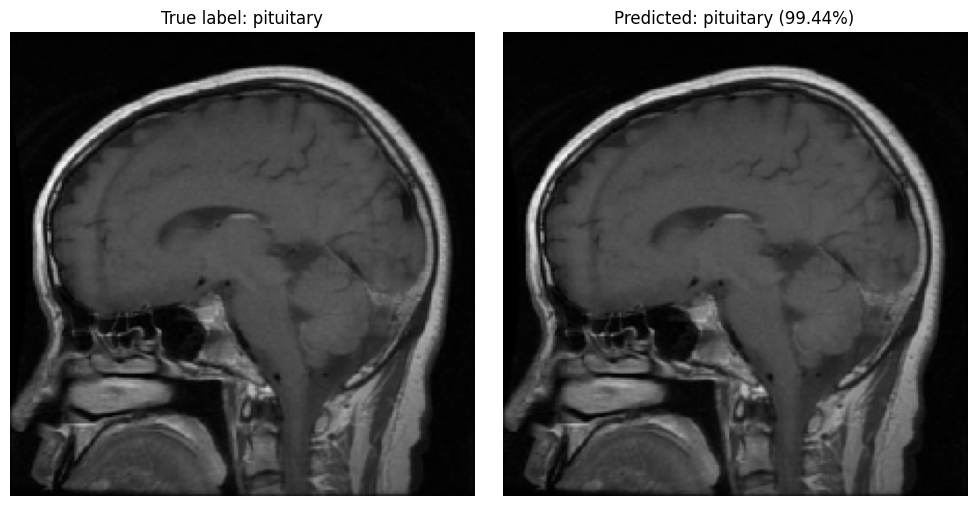

Actual class: pituitary
Predicted class: pituitary
Prediction confidence: 99.44%


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_single_image(model_path, test_df, train_gen):
    model = load_model(model_path)

    # Choose a random image from the test dataframe
    random_image = test_df.sample(n=1).iloc[0]
    img_path = random_image['filepaths']
    true_label = random_image['labels']


    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=1)
    class_labels = list(train_gen.class_indices.keys())
    predicted_label = class_labels[predicted_class[0]]
    prediction_confidence = preds[0][predicted_class[0]] * 100  # Convert to percentage

# Display the true image with the true label
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.load_img(img_path, target_size=(224, 224)))
    plt.title(f"True label: {true_label}")
    plt.axis('off')

    # Display the predicted image with the predicted label
    plt.subplot(1, 2, 2)
    plt.imshow(image.load_img(img_path, target_size=(224, 224)))
    plt.title(f"Predicted: {predicted_label} ({prediction_confidence:.2f}%)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Actual class: {true_label}")
    print(f"Predicted class: {predicted_label}")
    print(f"Prediction confidence: {prediction_confidence:.2f}%")

    return predicted_label, true_label, prediction_confidence

# Use the function to predict a new image
predicted_label, true_label, prediction_confidence = predict_single_image('best_model_efficientnet.h5', test_df, train_gen)

